Grawler Craton#

In [56]:
import pooch
import pygmt
import pyproj
import numpy as np
import xarray as xr
import pandas as pd
import verde as vd

In [57]:
fname = pooch.retrieve(
    url="https://dapds00.nci.org.au/thredds/fileServer/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/SA/line/P1282/P1282-line-magnetic.nc",
    known_hash="sha256:46145800ff94d63b4e24306cca02ccfb7613299542eb72ebf774839bd920e15f",
)

In [58]:
data = xr.load_dataset(fname)
data

<xarray.Dataset>
Dimensions:                            (point: 11879105, line: 1074)
Coordinates:
  * line                               (line) float64 3.19e+06 ... 3.106e+06
Dimensions without coordinates: point
Data variables: (12/17)
    line_index                         (point) float64 0.0 0.0 ... 1.073e+03
    FLIGHT                             (line) float64 1.015e+03 ... 1.015e+03
    bearing                            (line) float64 0.0 180.0 ... 270.0 90.0
    datecode                           (line) float64 2.017e+07 ... 2.017e+07
    survey                             (line) float64 1.282e+03 ... 1.282e+03
    dem_laser_microlevelled            (point) float64 112.6 112.5 ... 179.5
    ...                                 ...
    magnetics_final_microlevelled_1vd  (point) float64 0.05 0.05 ... -0.06 -0.06
    magnetics_final_tielevelled        (point) float64 71.68 71.31 ... 403.2
    radar_alt                          (point) float64 67.3 67.3 ... 88.0 87.8
    latitude                           (point) float64 -30.43 -30.43 ... -30.0
    longitude                          (point) float64 136.5 136.5 ... 138.0
    crs                                int8 -127
Attributes: (12/24)
    CreationTime:             Mon Nov 25 12:04:52 2019
    CreationMethod:           intrepid2netcdf.exe
    IntrepidSourceDataset:    GADDS_DATABASES/main/sa/GSSA_p1282MAG
    median_sample_spacing_m:  6.9
    geospatial_bounds:        POLYGON ((136.488082 -30.399303, 136.488461 -29...
    geospatial_lon_min:       136.4885335
    ...                       ...
    institution:              Commonwealth of Australia (Geoscience Australia)
    uuid:                     b07b4581-620a-47c2-901b-1e0aa18918f8
    Conventions:              CF-1.6, ACDD-1.3
    metadata_link:            http://pid.geoscience.gov.au/dataset/ga/143517
    keywords:                 Australia, Earth sciences, GADDS2.0, SA, airbor...
    licence:                  CC BY 3.0 (C) Department for Energy and Mining,...

In [59]:
gda_to_wgs = pyproj.Transformer.from_crs("epsg:4283", "epsg:4326", always_xy=True)
longitude, latitude = gda_to_wgs.transform(
    data.longitude.values, 
    data.latitude.values,
)

In [61]:
reducer = vd.BlockReduce(np.mean, spacing=0.005)
(lon, lat), mag = reducer.filter((longitude, latitude), data.magnetics_final_microlevelled.values)

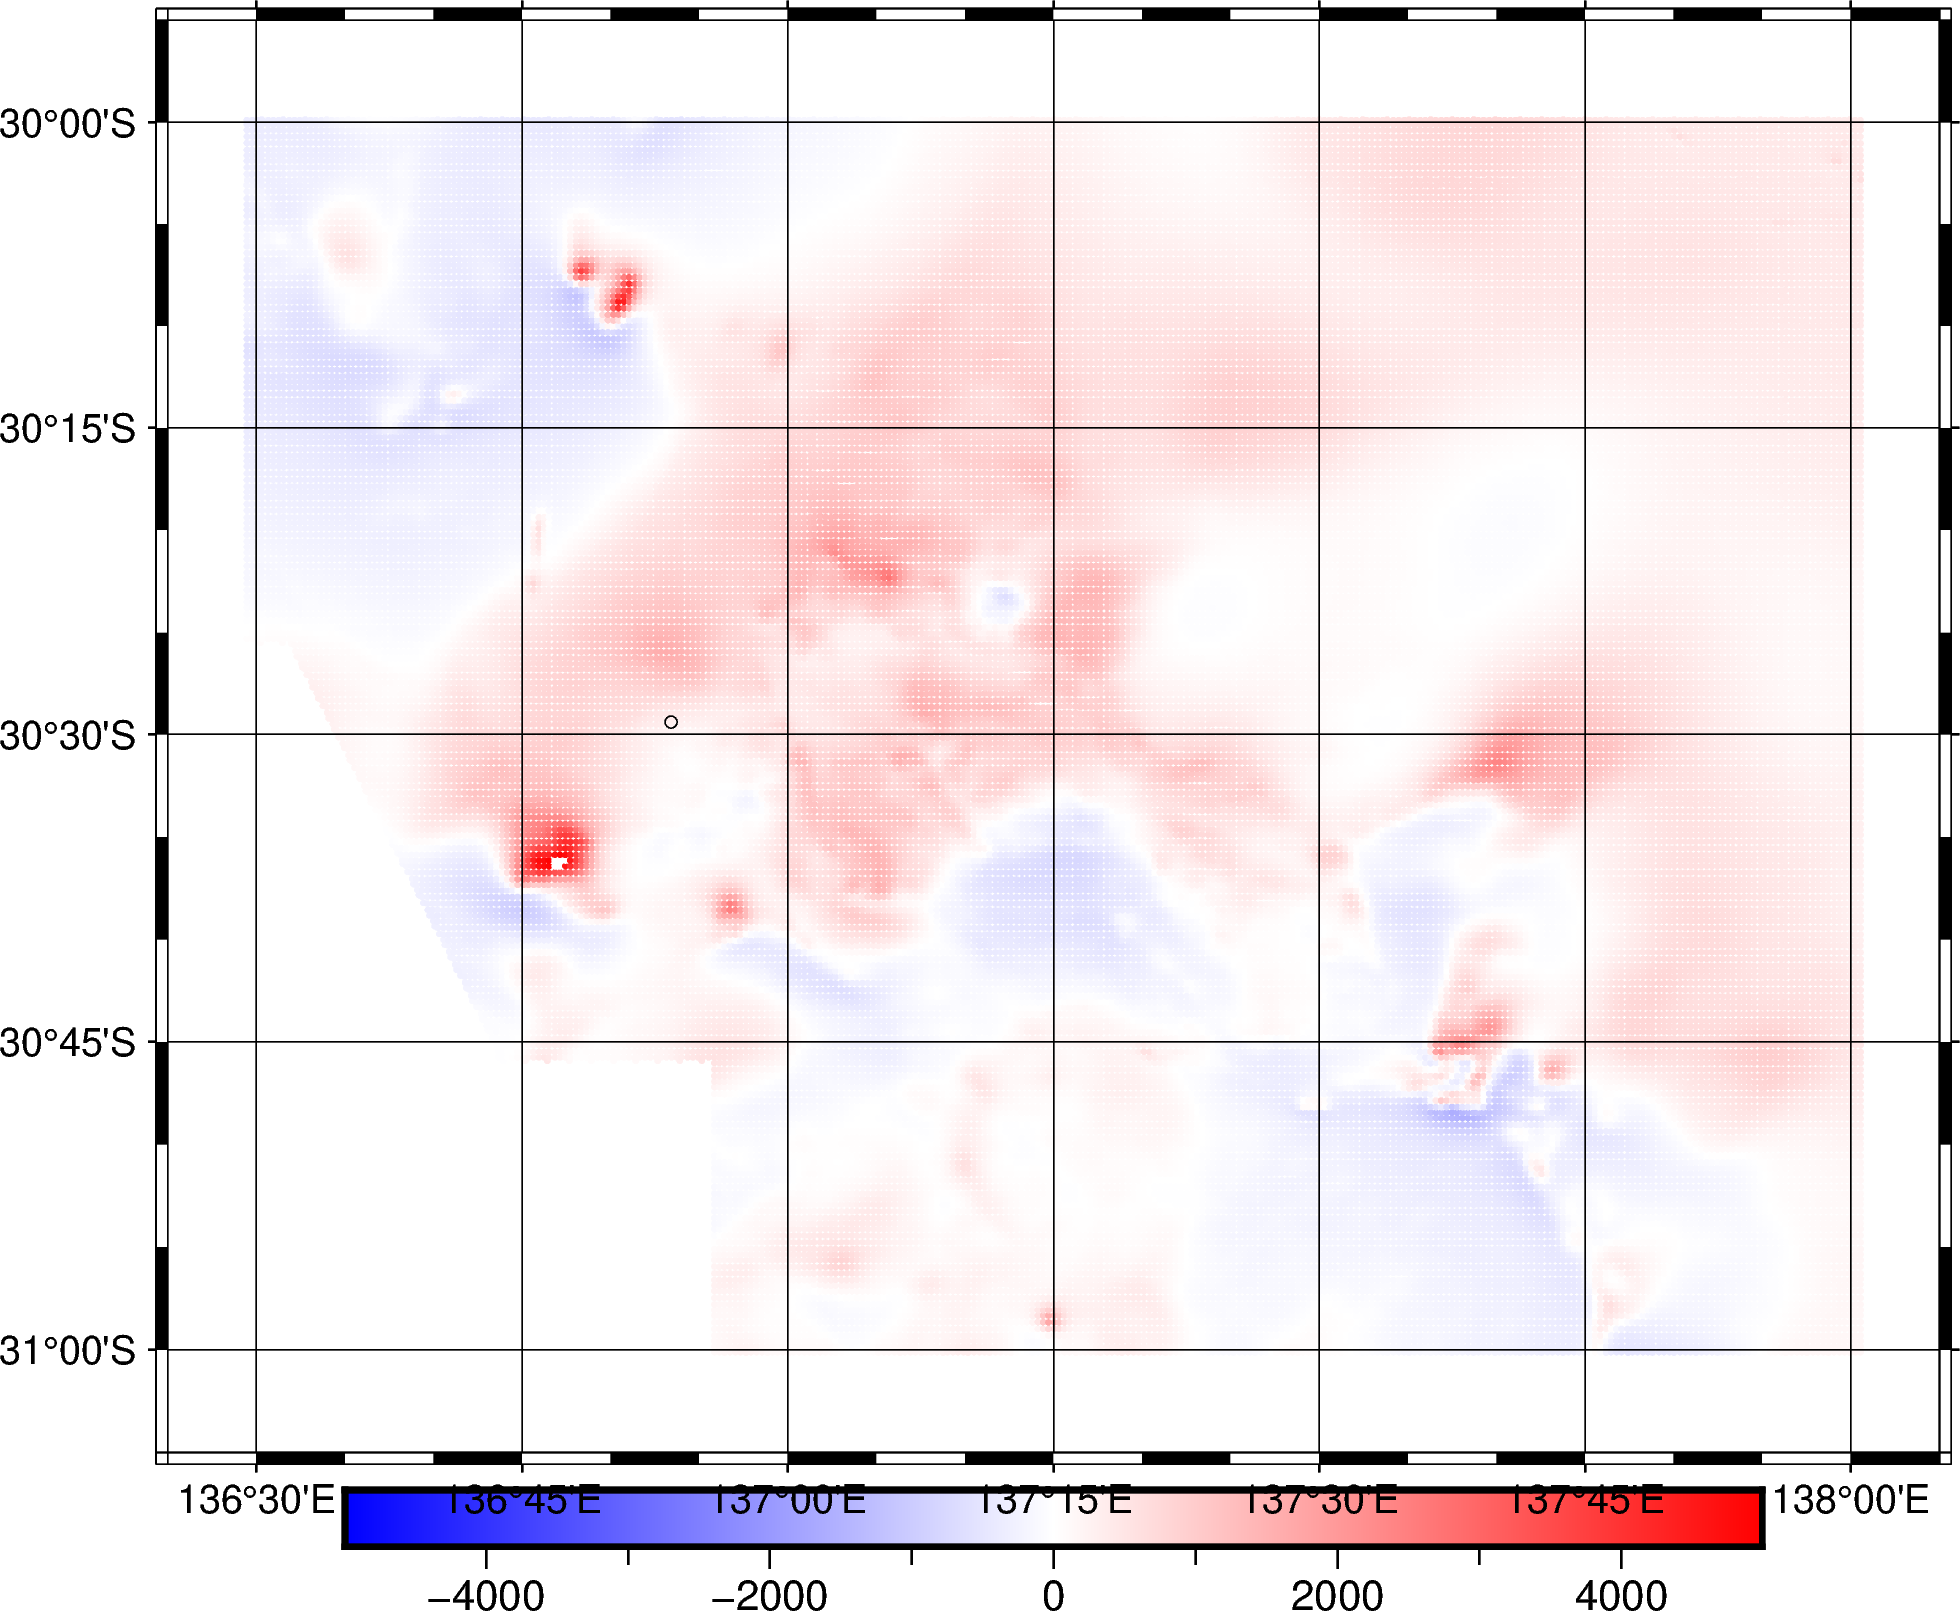

In [62]:
fig = pygmt.Figure()
scale = 0.9 * vd.maxabs(mag)
pygmt.makecpt(cmap="polar+h", series=[-scale, scale])
fig.plot(
    x=lon,
    y=lat,
    projection="M15c",
    color=mag,
    style="c0.05c",
    cmap=True,
)
fig.colorbar(frame="af")
# Olympic Dam
fig.plot(x=136.89, y=-30.49, style="c0.1c")
fig.basemap(frame="afg")
fig.show(width=1000)